<a href="https://colab.research.google.com/github/Priji123/Mtech_final_year_project/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SDNET2018_DECK_SUBSET_500

In [ ]:
import os
import random
import shutil

# ✅ CHANGE THIS PATH to your SDNET2018 folder inside Google Drive
SDNET_ROOT = "/content/drive/MyDrive/SDNET2018"

# ✅ DECK folders (common SDNET structure)
DECK_CRACKED = os.path.join(SDNET_ROOT, "Walls", "Cracked")
DECK_NONCRACKED = os.path.join(SDNET_ROOT, "Walls", "Non-cracked")

# ✅ Output subset folder
OUT_ROOT = "/content/drive/MyDrive/SDNET2018_WALLS_SUBSET_500"
OUT_CRACKED = os.path.join(OUT_ROOT, "cracked")
OUT_NONCRACKED = os.path.join(OUT_ROOT, "noncracked")

os.makedirs(OUT_CRACKED, exist_ok=True)
os.makedirs(OUT_NONCRACKED, exist_ok=True)

# ✅ Number of images to take from each class
N_CRACKED = 500
N_NONCRACKED = 500

def get_image_list(folder):
    valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_ext)]

cracked_list = get_image_list(DECK_CRACKED)
noncracked_list = get_image_list(DECK_NONCRACKED)

print("✅ Total Deck Cracked images:", len(cracked_list))
print("✅ Total Deck Non-cracked images:", len(noncracked_list))

# ✅ Shuffle and sample
random.shuffle(cracked_list)
random.shuffle(noncracked_list)

cracked_sample = cracked_list[:N_CRACKED]
noncracked_sample = noncracked_list[:N_NONCRACKED]

# ✅ Copy files
for i, src_path in enumerate(cracked_sample):
    dst_path = os.path.join(OUT_CRACKED, f"cracked_{i:04d}.jpg")
    shutil.copy(src_path, dst_path)

for i, src_path in enumerate(noncracked_sample):
    dst_path = os.path.join(OUT_NONCRACKED, f"noncracked_{i:04d}.jpg")
    shutil.copy(src_path, dst_path)

print("✅ Subset created successfully!")
print("📁 Saved at:", OUT_ROOT)
print("📂 Cracked:", len(os.listdir(OUT_CRACKED)))
print("📂 Non-cracked:", len(os.listdir(OUT_NONCRACKED)))


✅ Total Deck Cracked images: 3851
✅ Total Deck Non-cracked images: 14288


#Create images/ and masks/ folders

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# ✅ Your created subset folder
SUBSET_ROOT = "/content/drive/MyDrive/SDNET2018_WALLS_SUBSET_500"
CRACKED_DIR = os.path.join(SUBSET_ROOT, "cracked")
NONCRACKED_DIR = os.path.join(SUBSET_ROOT, "noncracked")

# ✅ Output folder for U-Net dataset
OUT_ROOT = "/content/drive/MyDrive/dataset_unet_wall"
IMG_OUT = os.path.join(OUT_ROOT, "images")
MASK_OUT = os.path.join(OUT_ROOT, "masks")

os.makedirs(IMG_OUT, exist_ok=True)
os.makedirs(MASK_OUT, exist_ok=True)

# ✅ Resize for fast training
IMG_SIZE = 256


#Crack Mask Generator Function

In [ ]:
def create_crack_mask(gray):
    """
    Input: grayscale image (H,W)
    Output: binary crack mask (H,W) with values 0 or 255
    """
    # ✅ Smooth but preserve edges
    blur = cv2.bilateralFilter(gray, 9, 75, 75)

    # ✅ Blackhat highlights dark cracks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, kernel)

    # ✅ Increase local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blackhat)

    # ✅ Edge detection
    edges = cv2.Canny(enhanced, 30, 120)

    # ✅ Connect broken edges
    k2 = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(edges, k2, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k2, iterations=2)

    # ✅ Remove small noise components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    min_area = 200
    clean = np.zeros_like(mask)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            clean[labels == i] = 255

    return clean


#Create dataset image-mask pairs (cracked + noncracked)

In [ ]:
import glob

cracked_paths = sorted(glob.glob(os.path.join(CRACKED_DIR, "*.*")))
noncracked_paths = sorted(glob.glob(os.path.join(NONCRACKED_DIR, "*.*")))

print("✅ Cracked images found:", len(cracked_paths))
print("✅ Non-cracked images found:", len(noncracked_paths))

idx = 0

# ✅ Process cracked images: mask generated from OpenCV
for path in tqdm(cracked_paths, desc="Generating masks for cracked"):
    img = cv2.imread(path)
    if img is None:
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask = create_crack_mask(gray)
    mask = (mask > 0).astype(np.uint8) * 255  # ensure 0/255

    name = f"{idx:05d}.png"
    cv2.imwrite(os.path.join(IMG_OUT, name), img)
    cv2.imwrite(os.path.join(MASK_OUT, name), mask)
    idx += 1

# ✅ Process non-cracked images: empty mask
for path in tqdm(noncracked_paths, desc="Generating empty masks for non-cracked"):
    img = cv2.imread(path)
    if img is None:
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    empty_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    name = f"{idx:05d}.png"
    cv2.imwrite(os.path.join(IMG_OUT, name), img)
    cv2.imwrite(os.path.join(MASK_OUT, name), empty_mask)
    idx += 1

print("✅ Done! Total saved pairs:", idx)
print("📁 Images saved in:", IMG_OUT)
print("📁 Masks saved in:", MASK_OUT)


# U-NET Training Code

##Import + Paths

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ✅ Path to your dataset
DATASET_ROOT = "/content/drive/MyDrive/dataset_unet_wall"
IMG_DIR = os.path.join(DATASET_ROOT, "images")
MASK_DIR = os.path.join(DATASET_ROOT, "masks")

IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20  # increase to 20 if time allows

print("✅ Images path:", IMG_DIR)
print("✅ Masks path :", MASK_DIR)


✅ Images path: /content/drive/MyDrive/dataset_unet_wall/images
✅ Masks path : /content/drive/MyDrive/dataset_unet_wall/masks


##Load Dataset

In [ ]:
def load_dataset(img_dir, mask_dir, img_size=256):
    images = []
    masks = []

    files = sorted(os.listdir(img_dir))

    for f in tqdm(files, desc="Loading images and masks"):
        img_path = os.path.join(img_dir, f)
        mask_path = os.path.join(mask_dir, f)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        # Resize
        img = cv2.resize(img, (img_size, img_size))
        mask = cv2.resize(mask, (img_size, img_size))

        # Normalize image
        img = img.astype(np.float32) / 255.0

        # Convert mask to 0/1
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)  # (H,W,1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, Y = load_dataset(IMG_DIR, MASK_DIR, IMG_SIZE)
print("✅ Dataset loaded!")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


Loading images and masks: 100%|██████████| 1000/1000 [11:41<00:00,  1.43it/s]


✅ Dataset loaded!
X shape: (1000, 256, 256, 3)
Y shape: (1000, 256, 256, 1)


##Train and Validate

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("✅ Train:", X_train.shape, Y_train.shape)
print("✅ Val  :", X_val.shape, Y_val.shape)


✅ Train: (800, 256, 256, 3) (800, 256, 256, 1)
✅ Val  : (200, 256, 256, 3) (200, 256, 256, 1)


##Build U-NET model

In [ ]:
import tensorflow as tf

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def unet_model(input_shape=(256, 256, 3)):   # ✅ change default to 256
    inputs = tf.keras.layers.Input(input_shape)

    # ✅ Encoder
    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # ✅ Bottleneck
    bn = conv_block(p4, 256)

    # ✅ Decoder
    u5 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(bn)
    u5 = tf.keras.layers.Concatenate()([u5, c4])
    c5 = conv_block(u5, 128)

    u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c3])
    c6 = conv_block(u6, 64)

    u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c2])
    c7 = conv_block(u7, 32)

    u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, padding="same")(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c1])
    c8 = conv_block(u8, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(c8)

    model = tf.keras.Model(inputs, outputs)
    return model


model = unet_model((IMG_SIZE, IMG_SIZE, 3))  # ✅ will become (256,256,3) automatically
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

## Dice Score Metrics + Compile

In [ ]:
import tensorflow as tf

# ✅ Metric (can keep thresholding)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin)

    return (2.0 * intersection + smooth) / (union + smooth)


# ✅ Dice loss (IMPORTANT: no thresholding here)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice


# ✅ Combined loss: BCE + Dice Loss
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


# ✅ Compile model with improved loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", dice_coef]
)


##Train U-Net Model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/unet_wall_best_256.h5",
        save_best_only=True,
        monitor="val_loss",
        mode="min"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

model.save("/content/drive/MyDrive/unet_wall_final_256.h5")
print("✅ Saved model in Google Drive!")


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9807 - dice_coef: 0.6881 - loss: 0.6726

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9807 - dice_coef: 0.6879 - loss: 0.6729 - val_accuracy: 0.9678 - val_dice_coef: 0.4222 - val_loss: 0.8540
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9849 - dice_coef: 0.6613 - loss: 0.7040 - val_accuracy: 0.9728 - val_dice_coef: 0.4243 - val_loss: 0.8543
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9840 - dice_coef: 0.6773 - loss: 0.6634

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9840 - dice_coef: 0.6772 - loss: 0.6634 - val_accuracy: 0.9667 - val_dice_coef: 0.4081 - val_loss: 0.8497
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9866 - dice_coef: 0.7136 - loss: 0.6230 - val_accuracy: 0.9772 - val_dice_coef: 0.3976 - val_loss: 0.8654
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9875 - dice_coef: 0.7327 - loss: 0.5950

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9875 - dice_coef: 0.7327 - loss: 0.5948 - val_accuracy: 0.9733 - val_dice_coef: 0.4486 - val_loss: 0.8034
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9861 - dice_coef: 0.7399 - loss: 0.5548 - val_accuracy: 0.9771 - val_dice_coef: 0.4075 - val_loss: 0.8326
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9874 - dice_coef: 0.7332 - loss: 0.5413

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9874 - dice_coef: 0.7331 - loss: 0.5415 - val_accuracy: 0.9730 - val_dice_coef: 0.4390 - val_loss: 0.7905
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9870 - dice_coef: 0.7358 - loss: 0.5167 - val_accuracy: 0.9774 - val_dice_coef: 0.3673 - val_loss: 0.8458
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9882 - dice_coef: 0.7901 - loss: 0.4633 - val_accuracy: 0.9782 - val_dice_coef: 0.3740 - val_loss: 0.8429


✅ Saved model in Google Drive!


##Plot Training Graph

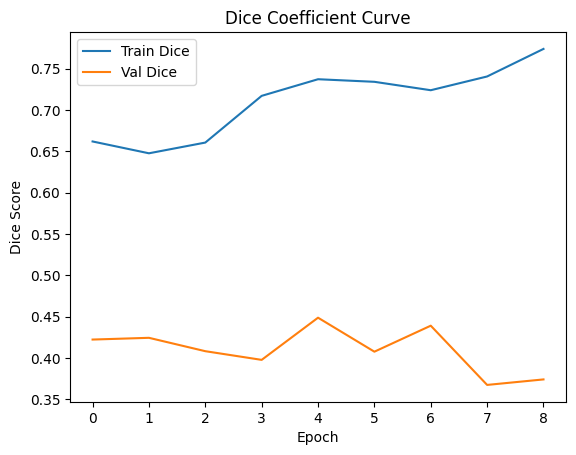

In [ ]:
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Val Loss")
# plt.title("Loss Curve")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

plt.plot(history.history["dice_coef"], label="Train Dice")
plt.plot(history.history["val_dice_coef"], label="Val Dice")
plt.title("Dice Coefficient Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.show()

